## Imports

In [1]:
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.spatialOperator import KNNQuery
from sedona.core.spatialOperator import JoinQuery
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import RangeQuery
from sedona.core.spatialOperator import RangeQueryRaw
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.formatMapper import WkbReader
from sedona.core.formatMapper import WktReader
from sedona.core.formatMapper import GeoJsonReader
from sedona.sql.types import GeometryType


from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyspark.sql.functions import expr
from pyspark.sql.functions import desc
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import first
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as pyspark_sum
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import count
from pyspark.sql.functions import explode
from sedona.core.SpatialRDD import SpatialRDD
from sedona.core.SpatialRDD import PointRDD
from sedona.core.SpatialRDD import PolygonRDD
from sedona.core.SpatialRDD import LineStringRDD
from sedona.core.enums import FileDataSplitter
from sedona.utils.adapter import Adapter
from sedona.core.enums import GridType
from sedona.core.SpatialRDD import RectangleRDD
from sedona.core.enums import IndexType
from sedona.core.geom.envelope import Envelope
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sedona.sql.types import GeometryType
from pyspark.sql.types import StructField
from pyspark.sql.types import StructType
from pyspark.sql.types import IntegerType
from sedona.utils.spatial_rdd_parser import GeoData
import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.pyplot import figure
from functions import create_grid

# Defining spark session

In [2]:
additional_packages = [
    # essential to use apache sedona
    "org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.1-incubating",
    # essential to use apache sedona
    "org.datasyslab:geotools-wrapper:geotools-24.0", 
    "org.postgresql:postgresql:42.2.23"  
]

In [3]:
additional_packages_string = ",".join(additional_packages)

In [ ]:
spark = SparkSession.\
    builder.\
    appName("apache-sedona").\
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config("spark.jars.packages", additional_packages_string) . \
    master("local[*]").\
    getOrCreate()

In [5]:
SedonaRegistrator.registerAll(spark)

True

# Reading the data from various data sources

### Reading the data from shapefile

In [6]:
mazovia_buildings = ShapefileReader.readToGeometryRDD(spark.sparkContext, "data/buildings")

In [7]:
mazovia_buildings

In [8]:
spark.createDataFrame(mazovia_buildings.rawSpatialRDD.map(lambda x: [x.geom.area, x.getUserData()])).show(3)

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|2.746610249998739...|5857805	1500	buil...|
|7.079225499953143E-8|5857806	1500	buil...|
|3.305160700000173E-7|8106732	1500	buil...|
+--------------------+--------------------+
only showing top 3 rows



### Converting SpatialRDD to Spatial Df using Adapter

In [9]:
Adapter.toDf(mazovia_buildings, spark).show(5)

+--------------------+--------+----+--------+--------------------+---------+
|            geometry|  osm_id|code|  fclass|                name|     type|
+--------------------+--------+----+--------+--------------------+---------+
|POLYGON ((21.0450...| 5857805|1500|building|UrzÄd Dzielnicy ...|city_hall|
|POLYGON ((21.0274...| 5857806|1500|building|UrzÄd Miasta i G...|city_hall|
|POLYGON ((21.0893...| 8106732|1500|building|  PaÅac w Wilanowie|   castle|
|POLYGON ((20.9698...|10156145|1500|building|Scena Na Woli Tea...|     hall|
|POLYGON ((20.9316...|15409904|1500|building|                    |         |
+--------------------+--------+----+--------+--------------------+---------+
only showing top 5 rows



In [10]:
Adapter.toDf(mazovia_buildings, spark).printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- osm_id: string (nullable = true)
 |-- code: string (nullable = true)
 |-- fclass: string (nullable = true)
 |-- name: string (nullable = true)
 |-- type: string (nullable = true)



## Reading data from geojson

{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },

{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "045", "TRACTCE": "021102", "BLKGRPCE": "4", "AFFGEOID": "1500000US010450211024", "GEOID": "010450211024", "NAME": "4", "LSAD": "BG", "ALAND": 11360854, "AWATER": 0 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -85.719017, 31.297901 ], [ -85.715626, 31.305203 ], [ -85.714271, 31.307096 ], [ -85.69999, 31.307552 ], [ -85.697419, 31.307951 ], [ -85.675603, 31.31218 ], [ -85.672733, 31.312876 ], [ -85.672275, 31.311977 ], [ -85.67145, 31.310988 ], [ -85.670622, 31.309524 ], [ -85.670729, 31.307622 ], [ -85.669876, 31.30666 ], [ -85.669796, 31.306224 ], [ -85.670356, 31.306178 ], [ -85.671664, 31.305583 ], [ -85.67177, 31.305299 ], [ -85.671878, 31.302764 ], [ -85.671344, 31.302123 ], [ -85.668276, 31.302076 ], [ -85.66566, 31.30093 ], [ -85.665687, 31.30022 ], [ -85.669183, 31.297677 ], [ -85.668703, 31.295638 ], [ -85.671985, 31.29314 ], [ -85.677177, 31.288211 ], [ -85.678452, 31.286376 ], [ -85.679236, 31.28285 ], [ -85.679195, 31.281426 ], [ -85.676865, 31.281049 ], [ -85.674661, 31.28008 ], [ -85.674377, 31.27935 ], [ -85.675714, 31.276882 ], [ -85.677938, 31.275168 ], [ -85.680348, 31.276814 ], [ -85.684032, 31.278848 ], [ -85.684387, 31.279082 ], [ -85.692398, 31.283499 ], [ -85.705032, 31.289718 ], [ -85.706755, 31.290476 ], [ -85.718102, 31.295204 ], [ -85.719132, 31.29689 ], [ -85.719017, 31.297901 ] ] ] } },

In [11]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(spark.sparkContext, "data/example.geojson")

In [12]:
geo_json_rdd

In [13]:
Adapter.toDf(geo_json_rdd, spark).printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- STATEFP: string (nullable = true)
 |-- COUNTYFP: string (nullable = true)
 |-- TRACTCE: string (nullable = true)
 |-- BLKGRPCE: string (nullable = true)
 |-- AFFGEOID: string (nullable = true)
 |-- GEOID: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LSAD: string (nullable = true)
 |-- ALAND: string (nullable = true)
 |-- AWATER: string (nullable = true)



In [14]:
Adapter.toDf(geo_json_rdd, spark).select("geometry", "STATEFP").show(5)

+--------------------+-------+
|            geometry|STATEFP|
+--------------------+-------+
|POLYGON ((-87.621...|     01|
|POLYGON ((-85.719...|     01|
|POLYGON ((-86.000...|     01|
|POLYGON ((-86.574...|     01|
|POLYGON ((-85.382...|     01|
+--------------------+-------+
only showing top 5 rows



## reading data from wkt

In [15]:
wkt_rdd = WktReader.readToGeometryRDD(spark.sparkContext, "data/county.tsv", 0, True, False)

In [16]:
wkt_rdd

In [17]:
Adapter.toDf(wkt_rdd, spark).printSchema()

root
 |-- geometry: geometry (nullable = true)



In [18]:
Adapter.toDf(wkt_rdd, spark).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



In [19]:
## or using dataframe API

In [20]:
spark.read.option("sep", "\t").csv("data/county.tsv").\
    selectExpr("ST_GeomFromWKT(_c0) AS geometry", "_c6 AS county_name").show(1)

+--------------------+-------------+
|            geometry|  county_name|
+--------------------+-------------+
|POLYGON ((-97.019...|Cuming County|
+--------------------+-------------+
only showing top 1 row



## reading data from wkb

In [21]:
wkb_rdd = WkbReader.readToGeometryRDD(spark.sparkContext, "data/county_wkb.tsv", 0, True, False)

In [22]:
wkb_rdd

In [23]:
Adapter.toDf(wkb_rdd, spark).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



Or directly using data frame api

In [24]:
spark.read.option("sep", "\t").csv("data/county_wkb.tsv").\
    selectExpr("ST_GeomFromWKB(_c0) AS geometry", "_c6 AS county_name").show(1)

+--------------------+-------------+
|            geometry|  county_name|
+--------------------+-------------+
|POLYGON ((-97.019...|Cuming County|
+--------------------+-------------+
only showing top 1 row



## Reading from PostGIS

In [25]:
counties = spark.read .\
  format("jdbc") .\
  option("url", "jdbc:postgresql://postgis:5432/sedona") .\
  option("dbtable", "counties") .\
  option("user", "sedona") .\
  option("password", "sedona") .\
  option("driver", "org.postgresql.Driver") .\
  load()

In [26]:
counties.selectExpr("geometry", "county_name").show(5)

+--------------------+----------------+
|            geometry|     county_name|
+--------------------+----------------+
|01030000000100000...|Jefferson County|
|01030000000100000...| Gonzales County|
|01030000000100000...|   Marion County|
|01030000000100000...|   Alpena County|
|01030000000100000...|    Wayne County|
+--------------------+----------------+
only showing top 5 rows



In [27]:
counties.selectExpr("ST_GeomFromWKB(geometry)", "county_name").show(5)

+------------------------+----------------+
|st_geomfromwkb(geometry)|     county_name|
+------------------------+----------------+
|    POLYGON ((-111.97...|Jefferson County|
|    POLYGON ((-97.727...| Gonzales County|
|    POLYGON ((-85.543...|   Marion County|
|    POLYGON ((-83.759...|   Alpena County|
|    POLYGON ((-85.044...|    Wayne County|
+------------------------+----------------+
only showing top 5 rows



# Integrating with other libraries

## geopandas

In [28]:
### geopandas -> geospatial data frame

In [29]:
point_data = [
    [1, Point(21, 52)],
    [2, Point(21, 52)]
]

gdf = gpd.GeoDataFrame(point_data, columns=["id", "geom"])

schema = StructType(
    [
        StructField("id", IntegerType(), False),
        StructField("geom", GeometryType(), False),
        
    ]
)

spark_gdf = spark.createDataFrame(gdf, schema)

In [30]:
spark_gdf.show()

+---+-------------+
| id|         geom|
+---+-------------+
|  1|POINT (21 52)|
|  2|POINT (21 52)|
+---+-------------+



In [31]:
### geospatial data frame to geopandas

In [32]:
point_data = [[1, "POINT(21 52)"], [2, "POINT(21 52)"]]

spark_gdf = spark.createDataFrame(point_data).\
    selectExpr("_1 AS id", "ST_GeomFromText(_2) AS geom")

pd_dataframe = spark_gdf.toPandas()

gdf = gpd.GeoDataFrame(pd_dataframe)


In [33]:
gdf

,id,geom
0,1,POINT (21 52)
1,2,POINT (21 52)


## Shapely

In [34]:
# shapely 

In [35]:
spark.createDataFrame([[0, Point(21, 52)]]).show()

+---+-------------+
| _1|           _2|
+---+-------------+
|  0|POINT (21 52)|
+---+-------------+



In [36]:
spark.read.option("sep", "\t").csv("data/county.tsv").\
    selectExpr("ST_GeomFromWKT(_c0) AS geometry", "_c6 AS county_name").collect()[:5]

[Row(geometry=<shapely.geometry.polygon.Polygon object at 0x7f0674b2ea90>, county_name='Cuming County'),
 Row(geometry=<shapely.geometry.polygon.Polygon object at 0x7f0674b2eb20>, county_name='Wahkiakum County'),
 Row(geometry=<shapely.geometry.polygon.Polygon object at 0x7f0674b2ebb0>, county_name='De Baca County'),
 Row(geometry=<shapely.geometry.polygon.Polygon object at 0x7f0674b2ec40>, county_name='Lancaster County'),
 Row(geometry=<shapely.geometry.polygon.Polygon object at 0x7f0674b2ecd0>, county_name='Nuckolls County')]

# Folium

In [37]:
spatial_df = spark.read.option("sep", "\t").csv("data/county.tsv").\
    selectExpr("ST_GeomFromWKT(_c0) AS geometry", "_c6 AS county_name", "CAST(_c1 AS int) AS count")

counties = gpd.GeoDataFrame(spatial_df.toPandas())

In [38]:
m = folium.Map(location=[33.70, -87.94], zoom_start=5, tiles='openstreetmap')

for _, r in counties.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['county_name']).add_to(geo_j)
    geo_j.add_to(m)
m

# matplotlib

In [39]:
spatial_df = spark.read.option("sep", "\t").csv("data/county.tsv").\
    selectExpr("ST_GeomFromWKT(_c0) AS geometry", "_c6 AS county_name", "CAST(_c1 AS int) AS count")

In [40]:
counties = gpd.GeoDataFrame(spatial_df.toPandas())

<AxesSubplot:>

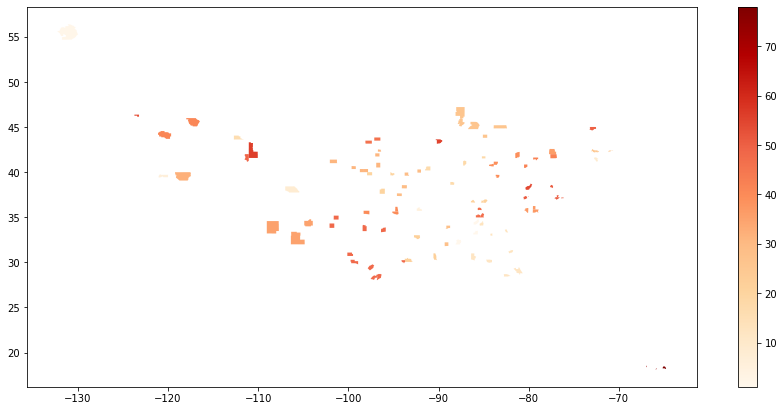

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
counties.plot(column='count', ax=ax, legend=True, cmap='OrRd')

# Spatial Join using DataFrames

### Preprocessing

In [42]:
taxi_data_raw = spark.read.option("header", "true").csv("data/taxi_data.csv").\
    selectExpr(
    "id",
    "vendor_id",
    "passenger_count",
    "DATE(CAST(pickup_datetime AS timestamp)) AS date",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude"
    ).where("date between '2016-01-01' AND '2016-01-05'")

In [43]:
dropoffs = taxi_data_raw.selectExpr(
    "id",
    "vendor_id",
    "passenger_count",
    """ST_Transform(
        ST_POINT(
            CAST(dropoff_longitude AS DECIMAL(38, 18)),
            CAST(dropoff_latitude AS DECIMAL(38, 18))
        ),
      'epsg:4326',
      'epsg:5070'
      ) AS geom""",
    "'drop' AS kind"
)

In [44]:
pickups = taxi_data_raw.selectExpr(
    "id",
    "vendor_id",
    "passenger_count",
    """ST_Transform(
        ST_POINT(
            CAST(pickup_longitude AS DECIMAL(38, 18)),
            CAST(pickup_latitude AS DECIMAL(38, 18))
        ),
      'epsg:4326',
      'epsg:5070'
      ) AS geom""",
    "'pickup' AS kind"
)

In [45]:
merged_data = dropoffs.unionByName(pickups)

In [46]:
manhattan = Polygon(
 [ 
     [ -74.017284545808806, 40.704273804196873 ],
     [ -74.007845772650597, 40.753966168765103 ],
     [ -73.945105692246017, 40.842524069867153 ],
     [ -73.945383303221249, 40.850297177173914 ],
     [ -73.923174425201935, 40.879446329574279 ],
     [ -73.907072988637921, 40.870840389341794 ],
     [ -73.935389308112562, 40.835861406461355 ],
     [ -73.929004255682003, 40.794497371150371 ],
     [ -73.943995248345047, 40.782004877264498 ],
     [ -73.941496749567875, 40.775897435809185 ],
     [ -73.975365288547337, 40.736199066349648 ],
     [ -73.970923512943472, 40.726482682216194 ],
     [ -73.977308565374031, 40.710381245652187 ],
     [ -74.012842770204941, 40.700664861518732 ],
     [ -74.017284545808806, 40.704273804196873 ] 
 ]
)

In [47]:
roads = ShapefileReader.readToGeometryRDD(spark.sparkContext, "data/roads_ny")
roads.analyze()
roads.spatialPartitioning(GridType.KDBTREE)

manhattan_roads = RangeQueryRaw.SpatialRangeQuery(roads, manhattan, True, False)

roads_df = Adapter.toDf(roads, spark).selectExpr(
    "osm_id",
    "ST_Transform(geometry, 'epsg:4326', 'epsg:5070') AS road_geom"
)

In [48]:
most_popular_roads = roads_df.join(merged_data, expr("ST_Distance(geom, road_geom) < 10")).\
    groupBy("osm_id", "kind").\
    agg(count("osm_id").alias("count"), first("road_geom").alias("road_geom")).\
    withColumn("road_geom", expr("ST_Transform(road_geom, 'epsg:5070', 'epsg:4326')")).\
    where("count > 1")

In [49]:
most_popular_roads.show()

21/09/20 21:18:35 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+---------+------+-----+--------------------+
|   osm_id|  kind|count|           road_geom|
+---------+------+-----+--------------------+
|421863334|pickup|    2|LINESTRING (-73.9...|
|464683324|pickup|    7|LINESTRING (-73.9...|
|509025002|  drop|    2|LINESTRING (-73.9...|
|532304640|pickup|    2|LINESTRING (-73.9...|
|793662100|  drop|    3|LINESTRING (-73.9...|
|375603434|pickup|    2|LINESTRING (-73.9...|
|433144115|pickup|    3|LINESTRING (-73.9...|
|515665879|pickup|    2|LINESTRING (-74.0...|
|527867877|  drop|    2|LINESTRING (-73.9...|
|616658930|pickup|    2|LINESTRING (-73.9...|
|660637194|  drop|    3|LINESTRING (-73.9...|
|663993423|  drop|    5|LINESTRING (-73.9...|
|664985018|  drop|    2|LINESTRING (-73.9...|
|793662044|pickup|    2|LINESTRING (-73.9...|
|834785572|  drop|    2|LINESTRING (-73.9...|
|894975078|pickup|    2|LINESTRING (-73.9...|
|918414172|  drop|    2|LINESTRING (-73.9...|
|937742005|  drop|    2|LINESTRING (-73.9...|
|226041002|  drop|    3|LINESTRING

In [50]:
## Grids with popular dropoff and pickup points

In [51]:
geo = gpd.GeoDataFrame([[1, create_grid(50, 30, 0.003, -74.02, 40.7)]], crs="epsg:4326", geometry=1)
geo.columns = ["id", "geom"]

In [52]:
m = folium.Map(location=[40.70, -73.94], zoom_start=14, tiles='openstreetmap')

for _, r in geo.iterrows():
    sim_geo = gpd.GeoSeries(r['geom'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    geo_j.add_to(m)
m

In [53]:
grid_sedona = spark.createDataFrame([[create_grid(50, 30, 0.003, -74.02, 40.7)]]).\
    select(explode(expr("ST_Dump(_1) AS geom")).alias("grid_geom"), monotonically_increasing_id().alias("id"))

In [54]:
pickdrop_points = merged_data.\
    withColumn("geom", expr("ST_Transform(geom, 'epsg:5070', 'epsg:4326')"))

In [55]:
passengers_by_grid = grid_sedona.alias("grid").\
    join(pickdrop_points.alias("taxi"), expr("ST_Intersects(taxi.geom, grid.grid_geom)")).\
    groupBy("grid.id").\
    agg(pyspark_sum("taxi.passenger_count").alias("passengers"), first("grid.grid_geom").alias("geom"))

In [56]:
passengers_by_grid.show()

21/09/20 21:19:11 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+-----------+----------+--------------------+
|         id|passengers|                geom|
+-----------+----------+--------------------+
|25769803859|      11.0|POLYGON ((-73.951...|
|25769804049|      23.0|POLYGON ((-74.011...|
|25769804292|      65.0|POLYGON ((-74.002...|
|25769804668|     123.0|POLYGON ((-73.954...|
|25769804731|      31.0|POLYGON ((-73.945...|
|25769803830|       1.0|POLYGON ((-73.948...|
|25769803831|       6.0|POLYGON ((-73.945...|
|25769804266|     767.0|POLYGON ((-73.99 ...|
|25769804282|      10.0|POLYGON ((-73.942...|
|25769804504|       1.0|POLYGON ((-73.996...|
|25769804218|      18.0|POLYGON ((-73.954...|
|25769804271|     344.0|POLYGON ((-73.975...|
|25769804762|      31.0|POLYGON ((-73.942...|
|25769804732|      43.0|POLYGON ((-73.942...|
|25769805000|      16.0|POLYGON ((-73.948...|
|25769805181|      16.0|POLYGON ((-73.945...|
|25769804010|       6.0|POLYGON ((-73.948...|
|25769804085|     284.0|POLYGON ((-73.993...|
|25769805031|      24.0|POLYGON ((

In [57]:
passengers_by_grid_geopandas = gpd.GeoDataFrame(passengers_by_grid.toPandas(), geometry="geom", crs="epsg:4326")

21/09/20 21:19:29 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


In [58]:
m = folium.Map(location=[40.70, -73.94], zoom_start=14, tiles='openstreetmap')

folium.Choropleth(
    geo_data=passengers_by_grid_geopandas[["id", "geom"]],
    data=passengers_by_grid_geopandas[["id", "passengers"]],
    columns=["id", "passengers"],
    fill_color='YlGnBu',
    fill_opacity=1,
    key_on="feature.properties.id",
    line_opacity=0.2,
    legend_name="passengers",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000",
    name = "passengers",
    show=False,
    overlay=True,
    nan_fill_color = "White"
).add_to(m)

m

# Spatial Join using RDD

In [59]:
taxi_spatial_rdd = Adapter.toSpatialRdd(pickdrop_points, "geom")
taxi_spatial_rdd.analyze()
taxi_spatial_rdd.spatialPartitioning(GridType.QUADTREE)
taxi_spatial_rdd.buildIndex(IndexType.RTREE, True)


grids_rdd = spark.sparkContext.parallelize([
    GeoData(el, f"{index}") for index, el in enumerate([*create_grid(50, 30, 0.003, -74.02, 40.7)])
])
grids_spatial_rdd = PolygonRDD(grids_rdd)
grids_spatial_rdd.analyze()
grids_spatial_rdd.spatialPartitioning(taxi_spatial_rdd.getPartitioner())

In [60]:
passengers_by_grid_rdd_based = Adapter.toDf(JoinQueryRaw.SpatialJoinQueryFlat(grids_spatial_rdd, taxi_spatial_rdd, True, True),
             ["id", "vendor", "passenger_count", "kind"],
             ["index"],
             spark).\
    groupBy("index").\
    agg(pyspark_sum("passenger_count").alias("passengers"), first("rightgeometry").alias("geom"))

passengers_by_grid_rdd_based.show()

+-----+----------+--------------------+
|index|passengers|                geom|
+-----+----------+--------------------+
| 1159|      15.0|POLYGON ((-73.963...|
| 1436|      20.0|POLYGON ((-73.942...|
|  467|       1.0|POLYGON ((-73.969...|
|  829|      54.0|POLYGON ((-73.963...|
|  125|      87.0|POLYGON ((-74.005...|
|  800|     359.0|POLYGON ((-73.96 ...|
|  853|     320.0|POLYGON ((-73.981...|
|  944|      27.0|POLYGON ((-73.978...|
|  919|       2.0|POLYGON ((-73.963...|
|  926|      37.0|POLYGON ((-73.942...|
|  124|      69.0|POLYGON ((-74.008...|
|  591|       1.0|POLYGON ((-73.957...|
|  307|     168.0|POLYGON ((-73.999...|
|  475|       1.0|POLYGON ((-73.945...|
|  613|     681.0|POLYGON ((-73.981...|
|  718|       2.0|POLYGON ((-73.935...|
| 1043|      31.0|POLYGON ((-73.951...|
|  169|      27.0|POLYGON ((-73.963...|
|  205|       4.0|POLYGON ((-73.945...|
|  334|     310.0|POLYGON ((-74.008...|
+-----+----------+--------------------+
only showing top 20 rows



In [61]:
passengers_by_grid_geopandas_based_on_rdd = gpd.GeoDataFrame(
    passengers_by_grid_rdd_based.toPandas(),
    geometry="geom",
    crs="epsg:4326"
)

m = folium.Map(location=[40.70, -73.94], zoom_start=14, tiles='openstreetmap')

folium.Choropleth(
    geo_data=passengers_by_grid_geopandas_based_on_rdd[["index", "geom"]],
    data=passengers_by_grid_geopandas_based_on_rdd[["index", "passengers"]],
    columns=["index", "passengers"],
    fill_color='YlGnBu',
    fill_opacity=1,
    key_on="feature.properties.index",
    line_opacity=0.2,
    legend_name="passengers",
    smooth_factor=0,
    Highlight= True,
    line_color = "#0000",
    name = "passengers",
    show=False,
    overlay=True,
    nan_fill_color = "White"
).add_to(m)

m

# Spatial Broadcast join

In [62]:
pickdrop_points.cache().count()

67912

In [63]:
pickdrop_points = spark.read.parquet("data_parquet")

In [64]:
passengers_by_grid = grid_sedona.alias("grid").\
    join(broadcast(pickdrop_points).alias("taxi"), expr("ST_Intersects(taxi.geom, grid.grid_geom)")).\
    groupBy("grid.id").\
    agg(pyspark_sum("taxi.passenger_count").alias("passengers"), first("grid.grid_geom").alias("geom"))

In [65]:
passengers_by_grid.explain()

== Physical Plan ==
SortAggregate(key=[id#740L], functions=[sum(cast(passenger_count#1015 as double)), first(grid_geom#741, false)])
+- *(4) Sort [id#740L ASC NULLS FIRST], false, 0
   +- Exchange hashpartitioning(id#740L, 200), true, [id=#727]
      +- SortAggregate(key=[id#740L], functions=[partial_sum(cast(passenger_count#1015 as double)), partial_first(grid_geom#741, false)])
         +- *(3) Sort [id#740L ASC NULLS FIRST], false, 0
            +- *(3) Project [grid_geom#741, id#740L, passenger_count#1015]
               +- BroadcastIndexJoin grid_geom#741: geometry, RightSide, RightSide, true ST_Intersects(geom#1016, grid_geom#741)
                  :- *(2) Project [grid_geom#741, monotonically_increasing_id() AS id#740L]
                  :  +- Generate explode(st_dump(_1#736)), false, [grid_geom#741]
                  :     +- *(1) Scan ExistingRDD[_1#736]
                  +- SpatialIndex geom#1016: geometry, QUADTREE, [id=#705]
                     +- FileScan parquet [passeng

In [66]:
passengers_by_grid.printSchema()

root
 |-- id: long (nullable = false)
 |-- passengers: double (nullable = true)
 |-- geom: geometry (nullable = true)

